In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import seaborn as sns
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
import timeit
from sklearn.metrics import (accuracy_score, balanced_accuracy_score, classification_report, confusion_matrix)
import cv2
import shutil
from sklearn.model_selection import train_test_split

In [2]:
os.listdir('/kaggle/input/covid-pneumonia-ct-dataset/Covid Pneumonia CT Dataset')

['Pneumonia', 'Normal', 'Covid']

In [3]:
def get_classes(data_path, classes, data):
    print(f"----{data}----")
    images={}
    count=0

    for i in range(len(classes)):
        x=""
        if i==0:
          x="Covid"
        elif i==1:
          x="Normal"
        elif i==2:
          x="Pneumonia"
        imgs=os.listdir(os.path.join(data_path, x))
        images[i]=imgs
        count+=len(imgs)

    for k, v in images.items():
        print(
            f"Grade {k}-{classes[k]}: {len(v)} images, {round((len(v)*100)/count, 2)}%"
        )

    return images

def plot_classes(dict_classes, data_path, classes, data):
    for k, v in dict_classes.items():
        print(f"{data}-{classes[k]}")
        plt.figure(figsize=(10, 25))
        x=""
        if k==0:
          x="Covid"
        elif k==1:
          x="Normal"
        elif k==2:
          x="Pneumonia"
        for i in range(5):
            img_path=os.path.join(data_path, x, v[i])
            img=tf.keras.preprocessing.image.load_img(img_path)
            plt.subplot(1, 5, 1+i, xticks=[], yticks=[])
            plt.imshow(img)
            plt.title(f"{x}")
        plt.show()

In [4]:
class_names=['Covid', 'Normal', 'Pneumonia']

In [5]:
base_dir="/kaggle/input/covid-pneumonia-ct-dataset/Covid Pneumonia CT Dataset"

In [6]:
working_data_path = '/kaggle/working/dataset'

In [7]:
# Copy the dataset to a writable directory
if not os.path.exists(working_data_path):
    shutil.copytree(base_dir, working_data_path)

In [8]:
train_split = '/kaggle/working/dataset/train_split'  # New train data path (70%)
valid_split = '/kaggle/working/dataset/valid_split'  # New validation data path (10%)
test_split = '/kaggle/working/dataset/test_split'  # New test data path (20%)

In [9]:
# Create directories if they don't exist
os.makedirs(train_split, exist_ok=True)
os.makedirs(valid_split, exist_ok=True)
os.makedirs(test_split, exist_ok=True)

categories = os.listdir(base_dir)

In [10]:
# Split and copy data
for category in categories:
    category_path = os.path.join(base_dir, category)
    images = os.listdir(category_path)
    
    # Split the images into 70% train and 30% remaining (for test and validation)
    train_images, remaining_images = train_test_split(images, test_size=0.3, random_state=42)
    
    # Split remaining images into 2/3 test (20%) and 1/3 validation (10%)
    test_images, valid_images = train_test_split(remaining_images, test_size=1/3, random_state=42)
    
    # Create category subdirectories in the new train and valid directories
    train_category_path = os.path.join(train_split, category)
    test_category_path = os.path.join(test_split, category)
    valid_category_path = os.path.join(valid_split, category)
    os.makedirs(train_category_path, exist_ok=True)
    os.makedirs(test_category_path, exist_ok=True)
    os.makedirs(valid_category_path, exist_ok=True)
    
    # Copy images to the respective folders
    for img in train_images:
        shutil.copy(os.path.join(category_path, img), os.path.join(train_category_path, img))
    for img in test_images:
        shutil.copy(os.path.join(category_path, img), os.path.join(test_category_path, img))
    for img in valid_images:
        shutil.copy(os.path.join(category_path, img), os.path.join(valid_category_path, img))

print("Data split complete!")

Data split complete!


In [11]:
train_data=get_classes(train_split, class_names, 'Train')
test_data=get_classes(test_split, class_names, 'Test')
valid_data=get_classes(valid_split, class_names, 'Valid')

----Train----
Grade 0-Covid: 5315 images, 44.4%
Grade 1-Normal: 4825 images, 40.3%
Grade 2-Pneumonia: 1832 images, 15.3%
----Test----
Grade 0-Covid: 1518 images, 44.39%
Grade 1-Normal: 1378 images, 40.29%
Grade 2-Pneumonia: 524 images, 15.32%
----Valid----
Grade 0-Covid: 760 images, 44.39%
Grade 1-Normal: 690 images, 40.3%
Grade 2-Pneumonia: 262 images, 15.3%


Train data-Covid


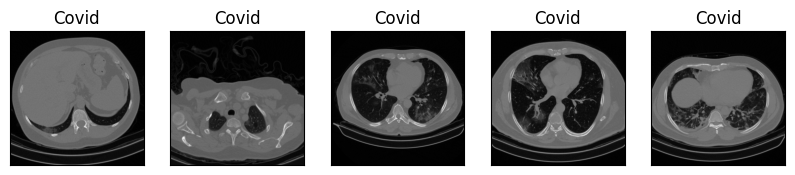

Train data-Normal


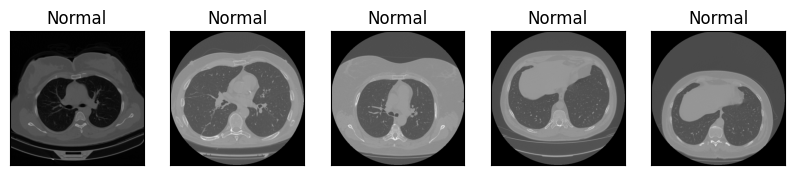

Train data-Pneumonia


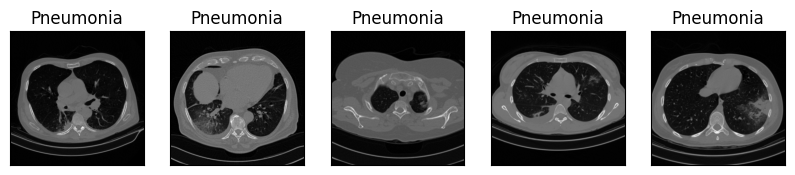

In [12]:
plot_classes(train_data, train_split, class_names, 'Train data')

In [13]:
def get_plot_loss_acc(model, model_name):
    fig=plt.figure()
    plt.subplot(2, 1, 1)
    plt.plot(model.history.history["loss"])
    plt.plot(model.history.history["val_loss"])
    plt.title(f"{model_name} \n\n model loss")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train", "valid"], loc="upper right")

    plt.subplot(2, 1, 2)
    plt.plot(model.history.history["accuracy"])
    plt.plot(model.history.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "valid"], loc="lower right")

    plt.tight_layout()

def compute_confusion_matrix(ytrue, ypred, class_names, model_name):
    cm=confusion_matrix(
        y_true=ytrue.labels,
        y_pred=np.argmax(ypred, axis=1),
    )
    cmn=cm.astype("float")/cm.sum(axis=1)[:, np.newaxis]
    plt.subplots(figsize=(6, 5))
    sns.heatmap(
        cmn,
        annot=True,
        fmt=".2f",
        cmap="Purples",
        xticklabels=class_names,
        yticklabels=class_names,
    )
    plt.title(f"Confusion Matrix - {model_name}")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show(block=False)

def get_evaluate(data, name, model):
    score_model=model.evaluate(data, verbose=1)
    print(f"{name} loss: {score_model[0]: .2f}")
    print(f"{name} accuracy: {score_model[1]: .2f}")

def get_predict(data, model):
    predict_model=model.predict(data)
    return predict_model

def get_metrics(y_test, y_pred, model_name):
    acc=accuracy_score(y_test, y_pred)
    bal_acc=balanced_accuracy_score(y_test, y_pred)

    print(f"Accuracy Score - {model_name}: {acc: .2f}")
    print(f"Balanced Accuracy Score - {model_name}: {bal_acc: .2f}")
    print("\n")

    print(classification_report(y_test, y_pred))

In [14]:
model_name="EfficientNet"

target_size=(224, 224)
epochs=10
batch_size=256
img_shape=(224, 224, 3)

save_model_ft=os.path.join('models', f'model_{model_name}_ft.hdf5')

In [15]:
aug_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet_v2.preprocess_input,
    horizontal_flip=True,
    brightness_range=[0.3, 0.8],
    width_shift_range=[-50, 0, 50, 30, -30],
    zoom_range=0.1,
    fill_mode="nearest",
)

noaug_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet_v2.preprocess_input,
)

Found 11972 images belonging to 3 classes.


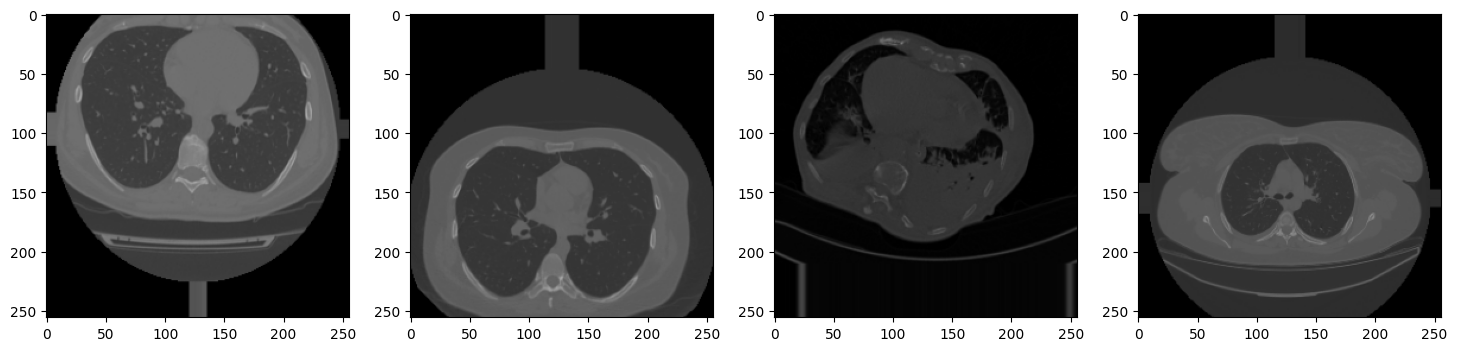

In [16]:
imagegen=aug_datagen.flow_from_directory(train_split, batch_size=1)
fig, rows=plt.subplots(nrows=1, ncols=4, figsize=(18, 18))
for row in rows:
    row.imshow(next(imagegen)[0][0].astype('uint8'))
plt.show()

In [17]:
train_generator = aug_datagen.flow_from_directory(
    train_split, class_mode="categorical", target_size=target_size, shuffle=True
)

valid_generator = noaug_datagen.flow_from_directory(
    valid_split,
    class_mode="categorical",
    target_size=target_size,
    shuffle=False,
)

Found 11972 images belonging to 3 classes.
Found 1712 images belonging to 3 classes.


In [18]:
y_train = train_generator.labels
y_val = valid_generator.labels

In [19]:
unique, counts = np.unique(y_train, return_counts=True)
print("Train: ", dict(zip(unique, counts)))

class_weights = compute_class_weight(
    class_weight="balanced", classes=np.unique(y_train), y=y_train
)
train_class_weights = dict(enumerate(class_weights))
print(train_class_weights)

Train:  {0: 5315, 1: 4825, 2: 1832}
{0: 0.7508309814989025, 1: 0.8270811744386873, 2: 2.178311499272198}


In [20]:
classes = np.unique(y_train)

# Callbacks
early = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', min_delta=0.01, patience=8,
            restore_best_weights=True
        )
plateau = tf.keras.callbacks.ReduceLROnPlateau(
                monitor='loss', factor=0.1, min_delta=0.01,
                min_lr=1e-10, patience=4, mode='auto'
            )

In [21]:
model = tf.keras.applications.EfficientNetV2B3(
    input_shape=(img_shape),
    include_top=False,
    weights="imagenet",
)

52606240/52606240 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [22]:
m=model.output

In [23]:
m = tf.keras.layers.GlobalAveragePooling2D()(m)
m = tf.keras.layers.Dropout(0.2)(m)

In [24]:
predictions = tf.keras.layers.Dense(3, activation='softmax')(m)

In [25]:
model_ft = tf.keras.models.Model(inputs=model.input, outputs=predictions)
model_ft.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          0 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │      1,080 │ normalization[0]… │
│                     │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        160 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │      5,760 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 112, 112,  │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 112, 112,  │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_co… │ (None, 112, 112,  │      2,304 │ block1a_project_… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_bn  │ (None, 112, 112,  │         64 │ block1b_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_ac… │ (None, 112, 112,  │          0 │ block1b_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_drop        │ (None, 112, 112,  │          0 │ block1b_project_… │
│ (Dropout)           │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_add (Add)   │ (None, 112, 112,  │          0 │ block1b_drop[0][… │
│                     │ 16)               │            │ block1a_project_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 56, 56,    │      9,216 │ block1b_add[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 56, 56,    │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 56, 56,    │          0 │ block2a_expand_b

 Total params: 12,935,233 (49.34 MB)

 Trainable params: 12,826,017 (48.93 MB)

 Non-trainable params: 109,216 (426.62 KB)

In [26]:
model_ft.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)

In [27]:
start_ft = timeit.default_timer()

history = model_ft.fit(
    train_generator,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=valid_generator,
    class_weight=train_class_weights,
    verbose=1,
)

stop_ft = timeit.default_timer()

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1728480052.921334     124 service.cc:145] XLA service 0x7e19840067e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728480052.921412     124 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1728480052.921418     124 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1728480164.138141     124 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_20', 40 bytes spill stores, 40 bytes spill loads

I0000 00:00:1728480164.257

 71/375 ━━━━━━━━━━━━━━━━━━━━ 2:20 462ms/step - accuracy: 0.6345 - loss: 0.7822

I0000 00:00:1728480313.069684     124 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion', 52 bytes spill stores, 52 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_multiply_reduce_fusion', 360 bytes spill stores, 360 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_multiply_reduce_fusion_1', 184 bytes spill stores, 184 bytes spill loads



375/375 ━━━━━━━━━━━━━━━━━━━━ 486s 824ms/step - accuracy: 0.7551 - loss: 0.5713 - val_accuracy: 0.7856 - val_loss: 0.4563
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 184s 480ms/step - accuracy: 0.9041 - loss: 0.2475 - val_accuracy: 0.8779 - val_loss: 0.3795
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 202s 481ms/step - accuracy: 0.9316 - loss: 0.1859 - val_accuracy: 0.8493 - val_loss: 0.5092
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 183s 480ms/step - accuracy: 0.9352 - loss: 0.1775 - val_accuracy: 0.8581 - val_loss: 0.3873
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 184s 482ms/step - accuracy: 0.9166 - loss: 0.2168 - val_accuracy: 0.9287 - val_loss: 0.1910
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 184s 481ms/step - accuracy: 0.9538 - loss: 0.1218 - val_accuracy: 0.9229 - val_loss: 0.1884
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 184s 482ms/step - accuracy: 0.9555 - loss: 0.1205 - val_accuracy: 0.8884 - val_loss: 0.2605
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 183s 479ms/step - accuracy: 0.9588 - loss: 0.10

In [28]:
execution_time_ft = (stop_ft - start_ft) / 60
print(
    f"Model {model_name} fine tuning executed in {execution_time_ft:.2f} minutes"
)

Model EfficientNet fine tuning executed in 35.93 minutes


In [29]:
model.save('/kaggle/working/EfficientNet.h5')

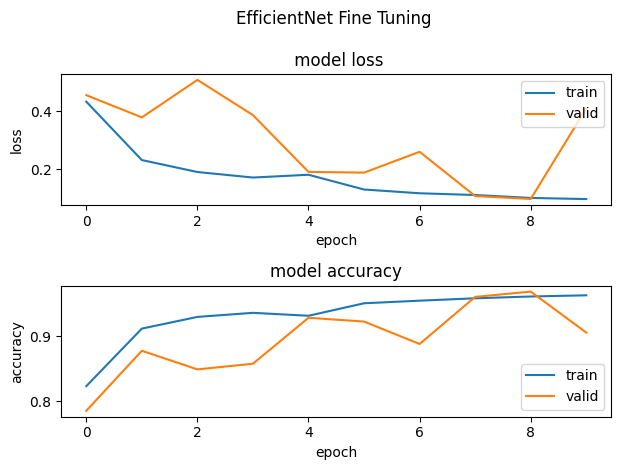

In [30]:
get_plot_loss_acc(model_ft, f"{model_name} Fine Tuning")

In [31]:
get_evaluate(train_generator, "Train", model_ft)

375/375 ━━━━━━━━━━━━━━━━━━━━ 175s 468ms/step - accuracy: 0.9695 - loss: 0.0948
Train loss:  0.09
Train accuracy:  0.97


In [32]:
get_evaluate(valid_generator, "Valid", model_ft)

54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9571 - loss: 0.1342
Valid loss:  0.41
Valid accuracy:  0.91


In [33]:
predict_model_ft = get_predict(valid_generator, model_ft)

get_metrics(
    valid_generator.labels,
    y_pred=np.argmax(predict_model_ft, axis=1),
    model_name=model_name,
)

54/54 ━━━━━━━━━━━━━━━━━━━━ 20s 253ms/step
Accuracy Score - EfficientNet:  0.91
Balanced Accuracy Score - EfficientNet:  0.84


              precision    recall  f1-score   support

           0       0.85      0.96      0.90       760
           1       0.95      0.96      0.96       690
           2       1.00      0.60      0.75       262

    accuracy                           0.91      1712
   macro avg       0.93      0.84      0.87      1712
weighted avg       0.91      0.91      0.90      1712



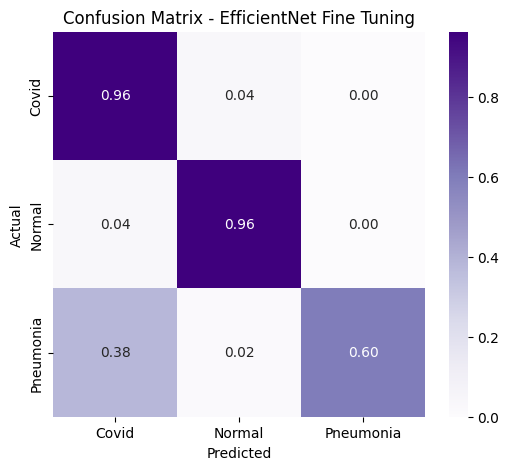

In [34]:
compute_confusion_matrix(
    valid_generator, predict_model_ft, class_names, f"{model_name} Fine Tuning"
)

In [35]:
test_generator = noaug_datagen.flow_from_directory(
    test_split,
    batch_size=batch_size,
    class_mode="categorical",
    target_size=target_size,
    shuffle=False,
)

Found 3420 images belonging to 3 classes.


In [36]:
EfficientNet = model_ft

In [37]:
predictions_efficientnet = EfficientNet.predict(test_generator)
score_efficientnet = EfficientNet.evaluate(test_generator, verbose=1)
print('Test loss:', score_efficientnet[0])
print('Test acc:', score_efficientnet[1])

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


14/14 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.9436 - loss: 0.1765
Test loss: 0.38502246141433716
Test acc: 0.9029240012168884


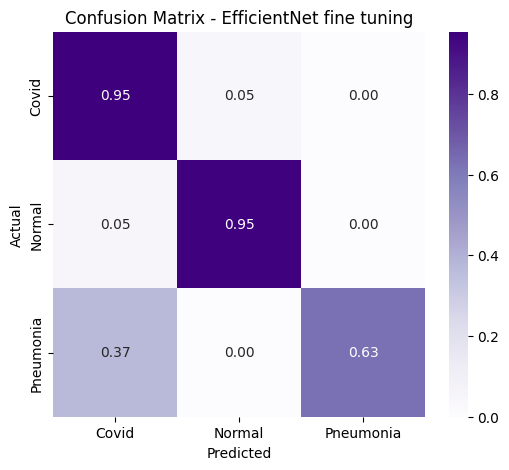

In [38]:
compute_confusion_matrix(
    test_generator,
    predictions_efficientnet,
    class_names,
    f"{model_name} fine tuning",
)

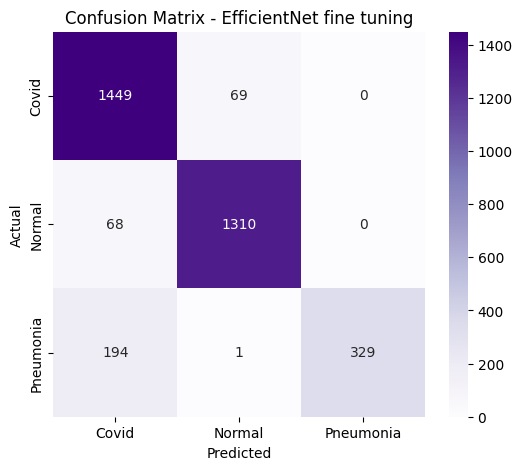

In [39]:
def count_confusion_matrix(ytrue, ypred, class_names, model_name):
    cm=confusion_matrix(
        y_true=ytrue.labels,
        y_pred=np.argmax(ypred, axis=1),
    )
    cmn=cm.astype("int")
    plt.subplots(figsize=(6, 5))
    sns.heatmap(
        cmn,
        annot=True,
        fmt=".0f",
        cmap="Purples",
        xticklabels=class_names,
        yticklabels=class_names,
    )
    plt.title(f"Confusion Matrix - {model_name}")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show(block=False)
    
count_confusion_matrix(
    test_generator,
    predictions_efficientnet,
    class_names,
    f"{model_name} fine tuning",
)

In [40]:
results = get_predict(test_generator, EfficientNet)

get_metrics(
    test_generator.labels,
    y_pred=np.argmax(results, axis=1),
    model_name=model_name,
)

14/14 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step
Accuracy Score - EfficientNet:  0.90
Balanced Accuracy Score - EfficientNet:  0.84


              precision    recall  f1-score   support

           0       0.85      0.95      0.90      1518
           1       0.95      0.95      0.95      1378
           2       1.00      0.63      0.77       524

    accuracy                           0.90      3420
   macro avg       0.93      0.84      0.87      3420
weighted avg       0.91      0.90      0.90      3420

